In [1]:
import numpy as np
import pickle
from cartopy import crs as ccrs, feature as cfeature
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import torch
import rdata
from mpl_toolkits.axes_grid1 import make_axes_locatable

In [2]:

with open("../data/prec_days.pkl", "rb") as f:
    prec_days = pickle.load(f)


lat = prec_days["lat"]
lon = prec_days["lon"]
obs = np.log(prec_days["precs"][:,:,0].T + 1e-10)
obs_orig = obs.copy()
locs = np.loadtxt("../data/locs.csv", skiprows=1, delimiter=",")
lat = locs[:, 1]
lon = locs[:, 0]
#obs = np.loadtxt("../data/prec-june1.csv", skiprows=1, delimiter=",").T
obsmean = np.mean(obs, axis=0, keepdims=True)
obssd = np.std(obs, axis=0, keepdims=True)
obs = (obs - obsmean) / obssd



with open('../results/dup_precipmodels_americas.pkl', 'rb') as f:
    precip_models = pickle.load(f)
shrink_models = precip_models["shrink_models"]
tm_models = precip_models["tm_models"]



#with open('../results/dup_precipmodels_americas_refactor.pkl', 'rb') as f:
#    results_refactor = pickle.load(f)
#shrink_models_refactor = results_refactor["shrink_models"]
#logscoresdata_refactor = torch.load('../results/dup_precipresults_americas_refactor.pt')
#logscores_shrink_refactor = logscoresdata_refactor['logscores_shrink']
#ModifNumTestSampleslist_refactor = logscoresdata_refactor['ModifNumTestSampleslist']



logscoresdata = torch.load('../results/dup_precipresults_americas.pt')
nTrain = logscoresdata["nTrain"]
logscores_tm = logscoresdata['logscores_tm']
logscores_shrink = logscoresdata['logscores_shrink']
ModifNumTestSampleslist = logscoresdata['ModifNumTestSampleslist']


locsorder = rdata.conversion.convert(rdata.parser.parse_file("../data/americas_ordering.RData"))["locsorder"]

/home/anirban0451/miniconda3/envs/shrink2param/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [4]:
finalscore_tm = torch.zeros((len(logscores_tm[0]), len(nTrain)))
finalscore_shrink = torch.zeros((len(logscores_shrink[0]), len(nTrain)))
#finalscore_shrink_refactor = torch.zeros((len(logscores_shrink_refactor[0]), len(nTrain)))
for i in range(len(nTrain)):
    finalscore_tm[:, i] = logscores_tm[i] / ModifNumTestSampleslist[i]
    finalscore_shrink[:, i] = logscores_shrink[i] / ModifNumTestSampleslist[i]
    #finalscore_shrink_refactor[:, i] = logscores_shrink_refactor[i] / ModifNumTestSampleslist_refactor[i]
#finalscore_dpm = torch.Tensor([torch.nan, -1685.266, -1476.333, -1240.4, -1001.3, -929.7, -710.8, -584.7])
finalscore_matern = torch.Tensor([-1360.2, -1348.17, -1346.44, -1368.8, -1362.8, -1364.5, -1365.5, -1345.9])

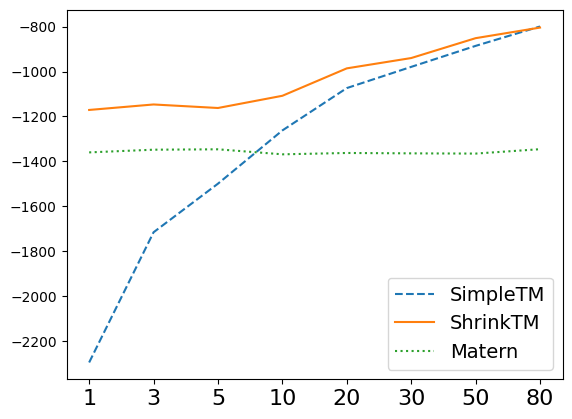

In [11]:
plt.plot(torch.arange(len(nTrain)), finalscore_tm.mean(dim=0), label="SimpleTM", linestyle = "dashed")
plt.plot(torch.arange(len(nTrain)), finalscore_shrink_refactor.mean(dim=0), label="ShrinkTM", linestyle = "solid")
#plt.plot(torch.arange(len(nTrain)), finalscore_shrink_refactor.mean(dim=0), label="ShrinkTM (refactor)", linestyle = "dashdot")
# plt.plot(torch.arange(len(nTrain)), finalscore_dpm, label="DPM + TM", linestyle = "dashdot")
plt.plot(torch.arange(len(nTrain)), finalscore_matern, label="Matern", linestyle = "dotted")
plt.legend(loc="lower right", fontsize = 14)
plt.xticks(torch.arange(len(nTrain)), labels = nTrain, fontsize = 16);
# plt.xlabel("Size of training data")

In [5]:
Ns = nTrain
reps = int(len(shrink_models)/ len(Ns))
nugget_shrink_factors = torch.zeros((len(Ns), reps))
for i, _ in enumerate(Ns):
    for j in range(reps):
        with torch.no_grad():
            nugget_shrink_factors[i, j] = shrink_models[i*reps + j].nugget_shrinkage_factor.exp()

mean_nug_shrink = nugget_shrink_factors.mean(dim = 1)
median_nug_shrink = nugget_shrink_factors.median(dim = 1).values
max_nug_shrink = nugget_shrink_factors.max(dim = 1).values
min_nug_shrink = nugget_shrink_factors.min(dim = 1).values

In [6]:
from batram.base_functions import compute_scale

sigmas = torch.zeros((locs.shape[0], len(nTrain), reps))
for i, _ in enumerate(nTrain):
    for j in range(reps):
        with torch.no_grad():
            sigmas[:, i, j] = shrink_models[i*reps + j].kernel._sigmas(compute_scale(shrink_models[i*reps + j].data.locs, shrink_models[i*reps + j].data.conditioning_sets))
from matplotlib import lines
sigmas_mean = sigmas.mean(dim=-1)
sigmas_min = sigmas.min(dim=-1).values
sigmas_max = sigmas.max(dim=-1).values

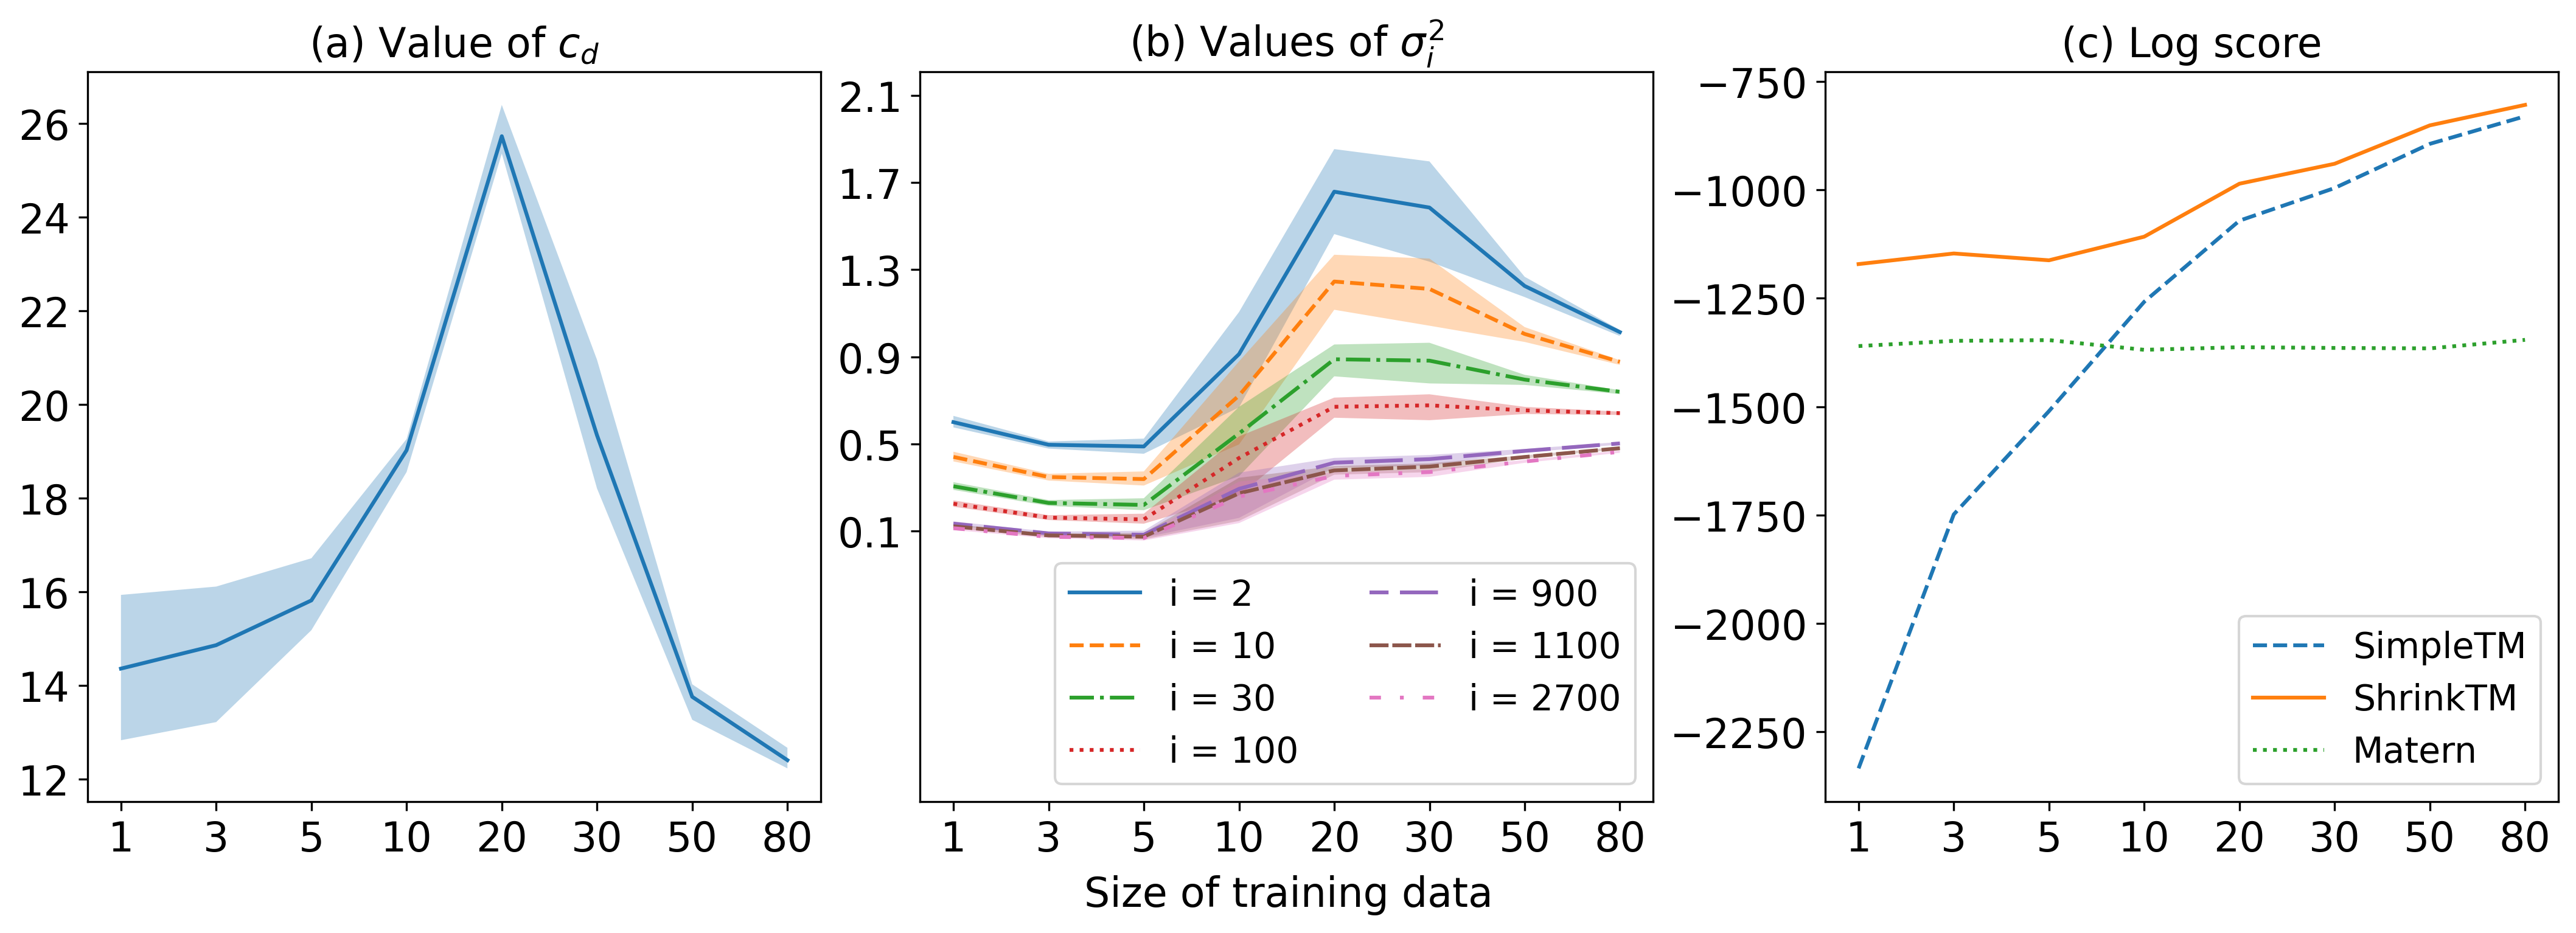

In [7]:
fig, ax = plt.subplots(1, 3, figsize=(14, 5), dpi = 300, layout = "constrained")

ax[0].plot(torch.arange(len(Ns)), mean_nug_shrink)
ax[0].fill_between(torch.arange(len(Ns)), min_nug_shrink, max_nug_shrink, alpha = 0.3)
ax[0].set_xticks(torch.arange(len(Ns)), Ns, fontsize = 16);
#ax[0].set_xlabel("Size of training data")
ax[0].set_title("(a) Value of $c_d$", fontsize = 16)
ax[0].tick_params(axis='both', labelsize=16)


linestl = ['-', '--', '-.', ':', (5, (10, 3)), (0, (5, 1)), (0, (3, 5, 1, 5))]

locstoplot = [1, 9, 29, 99, 899, 1099, 2699]
for i, _i in enumerate(locstoplot):
    ax[1].plot(torch.arange(len(nTrain)), sigmas_mean[_i, :], label=f"i = {_i + 1}", linestyle=linestl[i])
    ax[1].fill_between(torch.arange(len(nTrain)), sigmas_min[_i, :], sigmas_max[_i, :], alpha=0.3)
    ax[1].set_xticks(torch.arange(len(nTrain)), nTrain)
ax[1].tick_params(axis='both', labelsize=16)
#ax[1].set_xlabel("Size of training data")
ax[1].set_ylim(sigmas_min.min() - 1.2, sigmas_max.max() - 0.1)
ax[1].set_yticks(torch.arange(0.1, sigmas_max.max(), 0.4))
ax[1].legend(loc = "lower right", fontsize = 14, ncols = 2)
ax[1].set_title("(b) Values of $\sigma^2_i$", fontsize = 16)


ax[2].plot(torch.arange(len(nTrain)), finalscore_tm.mean(dim=0), label="SimpleTM", linestyle = "dashed")
ax[2].plot(torch.arange(len(nTrain)), finalscore_shrink.mean(dim=0), label="ShrinkTM", linestyle = "solid")
#ax[2].plot(torch.arange(len(nTrain)), finalscore_dpm, label="DPM + TM", linestyle = "dashdot")
ax[2].plot(torch.arange(len(nTrain)), finalscore_matern, label="Matern", linestyle = "dotted")
ax[2].legend(loc="lower right", fontsize = 14)
ax[2].set_xticks(torch.arange(len(nTrain)), labels = nTrain, fontsize = 16);
#ax[2].set_xlabel("Size of training data")
ax[2].tick_params(axis='both', labelsize=16)
ax[2].set_title("(c) Log score", fontsize = 16);
fig.supxlabel("Size of training data", fontsize = 16)
fig.savefig(f"../plots/climate_numerical_all.pdf", bbox_inches = "tight", dpi = 600)

In [8]:
Nplots = [1, 5, 10, 30, 50]
ncol = len(Nplots)
indices = np.random.randint(obs.shape[0], size = ncol)

In [9]:
maternmodels = rdata.conversion.convert(rdata.parser.parse_file("../results/matern_samples.RData"))
maternsamples = maternmodels["maternsamples"]
maternparams = maternmodels["params"]


In [17]:
rdata.conversion.convert(rdata.parser.parse_file("../results/matern_samples.RData"))["params"].shape

(15,)

In [17]:
NplotswithinN = [Ns.index(N) for N in Nplots]
samplestoplot = torch.zeros((2, ncol, obs.shape[1]))
np.random.seed(1002)
for j in range(ncol):
    samplestoplot[1, j, :] = tm_models[int(reps * NplotswithinN[j])].cond_sample().squeeze()
    samplestoplot[0, j, :] = shrink_models[int(reps * NplotswithinN[j])].cond_sample().squeeze()

samplestoplot = (samplestoplot.numpy())[:, :, locsorder.argsort()]

samplespart = torch.zeros((2, ncol, obs.shape[1]))
np.random.seed(2023)
obstor = torch.from_numpy(obs)
for j in range(ncol):
    samplespart[1, j, :] = tm_models[int(reps * NplotswithinN[j])].cond_sample(x_fix = (obstor[:,locsorder])[indices[0], :100]).squeeze()
    samplespart[0, j, :] = shrink_models[int(reps * NplotswithinN[j])].cond_sample(x_fix = (obstor[:,locsorder])[indices[0], :500]).squeeze()

samplespart = (samplespart.numpy())[:, :, locsorder.argsort()]

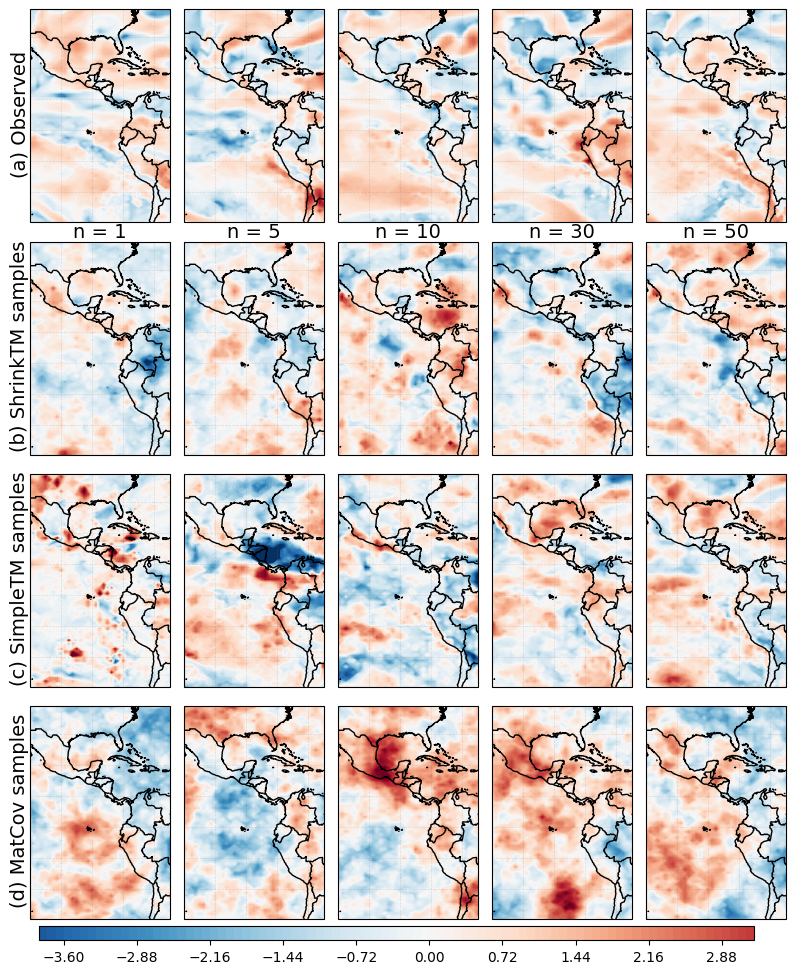

In [18]:
projPC = ccrs.PlateCarree()
lonTr2 = lon - 360
lonW = min(lonTr2)#180 - max(lon)
lonE = max(lonTr2)#180 - min(lon)
latS = min(lat)
latN = max(lat)
cLat = (latN + latS) / 2
cLon = (lonW + lonE) / 2
res = '50m'

nrow = 4
fig, ax = plt.subplots(nrow, ncol, figsize=(11,14),  subplot_kw={'projection': ccrs.PlateCarree()})
np.random.seed(10000)
vmin = -(np.abs(obs[indices, :]).max())
vmax = -vmin
for i in range(nrow):
    for j in range(ncol):
        #ax[i] = plt.subplot(1, 1, 1, projection=projPC)
        gl = ax[i, j].gridlines(
            draw_labels=False, linewidth=0.5, color='gray', alpha=0.2, linestyle='--'
        )
        ax[i, j].set_extent([lonW, lonE, latS, latN], crs=projPC)
        ax[i, j].coastlines(resolution=res, color='black')
        ax[i, j].add_feature(cfeature.BORDERS);
        lon2D, lat2D = np.meshgrid(np.unique(lon), np.unique(lat))
        lon2Dtr = 180 - lon2D
        lon2Dtr2 = lon2D - 360
        if (i == 0):
            data = obs[indices[j], :].reshape(lon2Dtr2.shape)
            
        elif (i == 1):
            data = samplestoplot[0, j, :].reshape(lon2Dtr2.shape)
            
        elif (i == 2):
            data = samplestoplot[1, j, :].reshape(lon2Dtr2.shape)
            
        elif (i == 3):
            data = maternsamples[j,:].reshape(lon2Dtr.shape)
            
        elif (i == 4):
            data = samplespart[0, j, :].reshape(lon2Dtr2.shape)
    
        elif (i == 5):
            data = samplespart[1, j, :].reshape(lon2Dtr2.shape)
        
        dataplot = ax[i, j].contourf(lon2Dtr2, lat2D, data, 100,
                                transform=ccrs.PlateCarree(), cmap = 'RdBu_r', vmin = vmin, vmax = vmax,
                                )
        if (j == 0):
            if (i == 0):
                ax[i, j].text(-116.5, 5.5, "(a) Observed", rotation=90, va = "center", fontsize = 14)
            elif (i == 1):
                ax[i, j].text(-116.5, 5.5, "(b) ShrinkTM samples", rotation=90, va = "center", fontsize = 14)
            elif (i == 2):
                ax[i, j].text(-116.5, 5.5, "(c) SimpleTM samples", rotation=90, va = "center", fontsize = 14)
            elif (i == 3):
                ax[i, j].text(-116.5, 5.5, "(d) MatCov samples", rotation=90, va = "center", fontsize = 14)
            elif (i == 4):
                ax[i, j].text(-115.5, 5.5, "(e) ShrinkTM samples\n (partially observed)", rotation=90, va = "center", ha = "center")
            elif (i == 5):
                ax[i, j].text(-115.5, 5.5, "(f) SimpleTM samples\n (partially observed)", rotation=90, va = "center", ha = "center")
        if (i == 1):
            ax[i, j].set_title("n = " + str(Nplots[j]), pad = 0.2, fontsize = 14)
#fig.tight_layout()
#fig.colorbar(dataplot, ax = ax, orientation = "horizontal", shrink = 0.8, location = "bottom", pad = -2, extend = 'both')
fig.subplots_adjust(left=0.2, wspace = 0.0005, hspace=0.09, bottom = 0.23)
cbar_ax = fig.add_axes(rect=[0.215, 0.215, 0.65, 0.01])
cbar_ax.set_aspect('auto')
#cbar_ax.can_zoom()
plt.colorbar(dataplot, cax = cbar_ax, shrink = 1.0, orientation = "horizontal")
fig.savefig('../plots/precip_all.pdf', bbox_inches='tight')

In [19]:
import math
lat = locs[:, 1]
lon = locs[:, 0]
l=(lon/360)*2*math.pi; L=(lat/360)*2*math.pi
locs3D=np.vstack([np.cos(L)*np.cos(l),np.cos(L)*np.sin(l),np.sin(L)]).T
locs3Dord = locs3D[np.intp(locsorder), :]

In [20]:
from sklearn.gaussian_process.kernels import Matern
from scipy import linalg, stats
xfixlocs = 100
x_fix = (obstor[:,locsorder])[indices[0], :xfixlocs]

In [21]:
maternpartsamples = np.zeros(shape=((ncol, obs.shape[1])))
MaternKernel = Matern(nu = 1.5)

In [22]:
for i in range(maternpartsamples.shape[0]):
    MaternKernel.set_params(length_scale = math.exp(maternparams[3*i + 1]), nu = math.exp(maternparams[3*i + 2]))
    maternpartsamples[i, :xfixlocs] = x_fix.numpy()

    materncovoo = MaternKernel(locs3Dord[:xfixlocs, :])
    materncovou = MaternKernel(locs3Dord[xfixlocs:, :], locs3Dord[:xfixlocs, :])
    materncovuu = MaternKernel(locs3Dord[xfixlocs:, :])

    maternpostmean = materncovou @ linalg.solve(materncovoo, x_fix.numpy().T)
    maternpostcovuu = math.exp(maternparams[3*i]) * (materncovuu - materncovou @ linalg.solve(materncovoo, materncovou.T))
    maternpartsamples[i, xfixlocs:] = stats.multivariate_normal.rvs(maternpostmean.squeeze(), maternpostcovuu)

maternpartsamples = maternpartsamples[:, locsorder.argsort()]

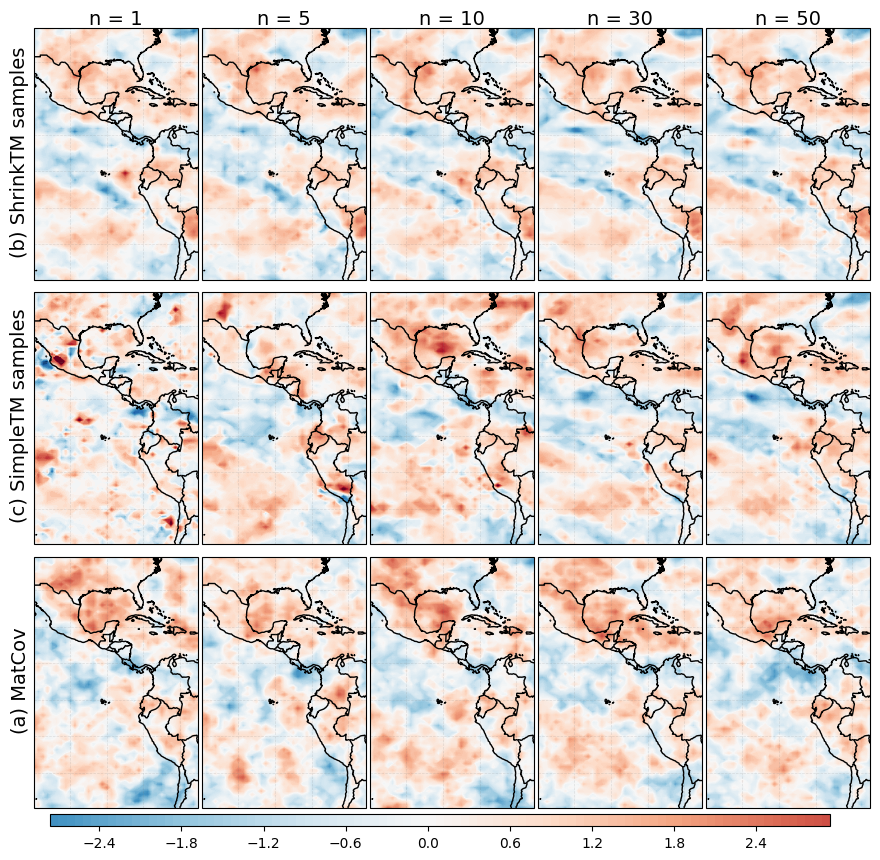

In [24]:
projPC = ccrs.PlateCarree()
lonTr2 = lon - 360
lonW = min(lonTr2)#180 - max(lon)
lonE = max(lonTr2)#180 - min(lon)
latS = min(lat)
latN = max(lat)
cLat = (latN + latS) / 2
cLon = (lonW + lonE) / 2
res = '50m'

nrow = 3
fig, ax = plt.subplots(nrow, ncol, figsize=(12,12),  subplot_kw={'projection': ccrs.PlateCarree()})
np.random.seed(10000)
vmin = -(np.abs(obs[indices, :]).max())
vmax = -vmin
for i in range(nrow):
    for j in range(ncol):
        #ax[i] = plt.subplot(1, 1, 1, projection=projPC)
        gl = ax[i, j].gridlines(
            draw_labels=False, linewidth=0.5, color='gray', alpha=0.2, linestyle='--'
        )
        ax[i, j].set_extent([lonW, lonE, latS, latN], crs=projPC)
        ax[i, j].coastlines(resolution=res, color='black')
        ax[i, j].add_feature(cfeature.BORDERS);
        lon2D, lat2D = np.meshgrid(np.unique(lon), np.unique(lat))
        lon2Dtr = 180 - lon2D
        lon2Dtr2 = lon2D - 360
        if (i == 2):
            data = maternpartsamples[j,:].reshape(lon2Dtr.shape)
            #else:
            #    continue
        elif (i == 0):
            data = samplespart[0, j, :].reshape(lon2Dtr2.shape)
    
        elif (i == 1):
            data = samplespart[1, j, :].reshape(lon2Dtr2.shape)
        
        dataplot = ax[i, j].contourf(lon2Dtr2, lat2D, data, 100,
                                transform=ccrs.PlateCarree(), cmap = 'RdBu_r', vmin = vmin, vmax = vmax,
                                )
        if (j == 0):
            if (i == 2):
                ax[i, j].text(-116.5, 5.5, "(a) MatCov", rotation=90, va = "center", fontsize = 14)
            elif (i == 0):
                ax[i, j].text(-116.5, 5.5, "(b) ShrinkTM samples", rotation=90, va = "center", fontsize = 14)
            elif (i == 1):
                ax[i, j].text(-116.5, 5.5, "(c) SimpleTM samples", rotation=90, va = "center", fontsize = 14)
        if (i == 0):
            ax[i, j].set_title("n = " + str(Nplots[j]), pad = 0.2, fontsize = 14)
#fig.tight_layout()
#fig.colorbar(dataplot, ax = ax, orientation = "horizontal", shrink = 0.8, location = "bottom", pad = -2, extend = 'both')
fig.subplots_adjust(left=0.2, wspace = 0.001, hspace=0.05, bottom = 0.23)
cbar_ax = fig.add_axes(rect=[0.215, 0.215, 0.65, 0.01])
cbar_ax.set_aspect('auto')
#cbar_ax.can_zoom()
plt.colorbar(dataplot, cax = cbar_ax, shrink = 1.0, orientation = "horizontal")
fig.savefig('../plots/precip_parts.pdf', bbox_inches='tight')

KeyboardInterrupt: 

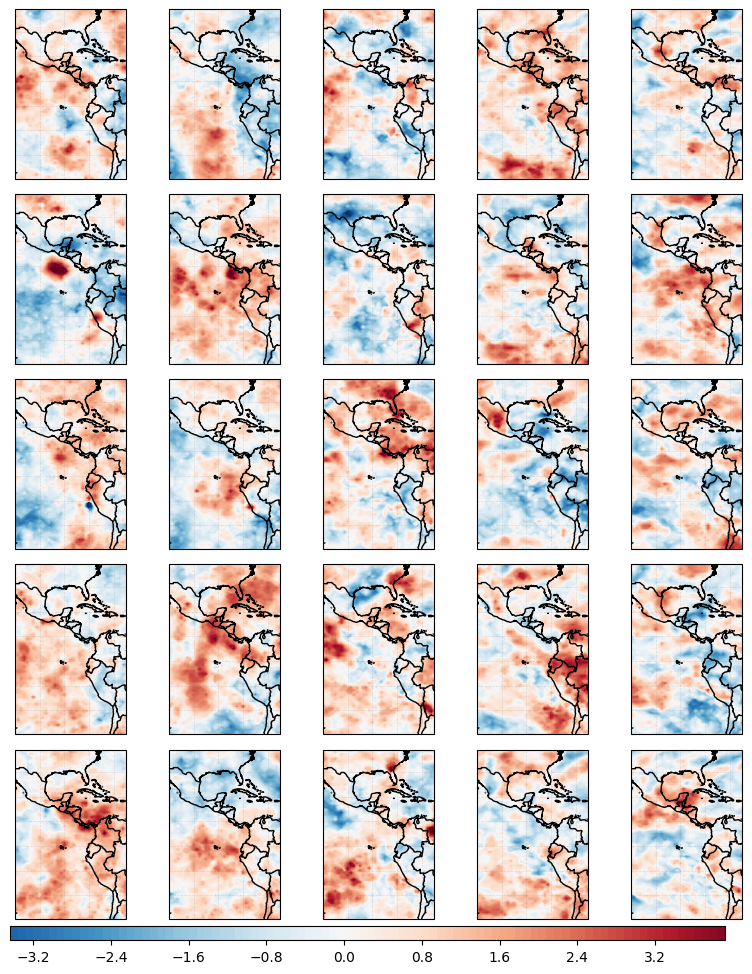

In [25]:
instances = [0, 1, 2, 3, 4, 5]
Nplots = [1, 5, 10, 30, 50]
Ns = nTrain
ncol = len(Nplots)
reps = 10
indices = np.random.randint(obs.shape[0], size = ncol)
for instance in instances:
    projPC = ccrs.PlateCarree()
    lonTr2 = lon - 360
    lonW = min(lonTr2)#180 - max(lon)
    lonE = max(lonTr2)#180 - min(lon)
    latS = min(lat)
    latN = max(lat)
    cLat = (latN + latS) / 2
    cLon = (lonW + lonE) / 2
    res = '50m'
    nrow = 5
    NplotswithinN = [Ns.index(N) for N in Nplots]
    samplestoplot = torch.zeros((ncol, nrow, obs.shape[1]))
    np.random.seed(1002)
    for j in range(ncol):
        samplestoplot[j, :, :] = shrink_models_refactor[int(reps * NplotswithinN[j]) + instance].cond_sample(num_samples = nrow).squeeze()

    samplestoplot = (samplestoplot.numpy())[:, :, locsorder.argsort()]


    fig, ax = plt.subplots(nrow, ncol, figsize=(11,14),  subplot_kw={'projection': ccrs.PlateCarree()})
    np.random.seed(10000)
    vmin = -(np.abs(obs[indices, :]).max())
    vmax = -vmin

    for i in range(nrow):
        for j in range(ncol):
            #ax[i] = plt.subplot(1, 1, 1, projection=projPC)
            gl = ax[i, j].gridlines(
                draw_labels=False, linewidth=0.5, color='gray', alpha=0.2, linestyle='--'
            )
            ax[i, j].set_extent([lonW, lonE, latS, latN], crs=projPC)
            ax[i, j].coastlines(resolution=res, color='black')
            ax[i, j].add_feature(cfeature.BORDERS);
            lon2D, lat2D = np.meshgrid(np.unique(lon), np.unique(lat))
            lon2Dtr = 180 - lon2D
            lon2Dtr2 = lon2D - 360
            
            data = samplestoplot[j, i, :].reshape(lon2Dtr2.shape)
            
            dataplot = ax[i, j].contourf(lon2Dtr2, lat2D, data, 100,
                                    transform=ccrs.PlateCarree(), cmap = 'RdBu_r', vmin = vmin, vmax = vmax,
                                    )
    #fig.tight_layout()
    #fig.colorbar(dataplot, ax = ax, orientation = "horizontal", shrink = 0.8, location = "bottom", pad = -2, extend = 'both')
    fig.subplots_adjust(left=0.2, wspace = 0.0005, hspace=0.09, bottom = 0.23)
    cbar_ax = fig.add_axes(rect=[0.215, 0.215, 0.65, 0.01])
    cbar_ax.set_aspect('auto')
    #cbar_ax.can_zoom()
    plt.colorbar(dataplot, cax = cbar_ax, shrink = 1.0, orientation = "horizontal")
    fig.savefig(f'../plots/instance_{instance}_model2.pdf', bbox_inches='tight')

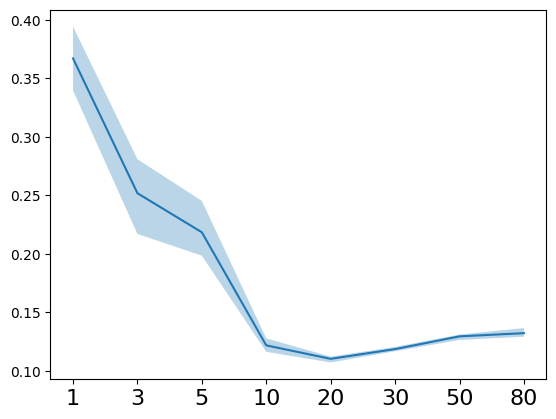

In [ ]:
f_shrink_factors = torch.zeros((len(Ns), reps))
for i, _ in enumerate(Ns):
    for j in range(reps):
        with torch.no_grad():
            f_shrink_factors[i, j] = shrink_models_refactor[i*reps + j].kernel.shrink_f.exp()

mean_f_shrink = f_shrink_factors.mean(dim = 1)
median_f_shrink = f_shrink_factors.median(dim = 1).values
max_f_shrink = f_shrink_factors.max(dim = 1).values
min_f_shrink = f_shrink_factors.min(dim = 1).values

plt.plot(torch.arange(len(Ns)), mean_f_shrink)
plt.fill_between(torch.arange(len(Ns)), min_f_shrink, max_f_shrink, alpha = 0.3)
plt.xticks(torch.arange(len(Ns)), Ns, fontsize = 16);